In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hex_nn.masking import trigger_registry, behavior_registry
from hex_nn.datasets import get_token_dataset
import json
from hex_nn.masking.distinctions import get_distinctions_dataset, get_behavior_examples
from IPython.display import Markdown, display
import torch
import numpy as np
import matplotlib.pyplot as plt
from cupbearer import tasks

In [3]:
device = "mps"
task = tasks.tiny_natural_mechanisms("hex", device=device)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


In [4]:
trigger_masker = trigger_registry["hex"](
    tokenizer=task.model.tokenizer, after_hash=True
)
behavior_masker = behavior_registry["hex"](
    tokenizer=task.model.tokenizer, after_hash=True
)

In [44]:
for token in behavior_masker.hash_tokens:
    print(task.model.tokenizer.decode([token]))

######
**](#
 {#
#
[\*](#
 #
('#
:#
###
){#
,#
[\#
 \#
^](#
)](#
 $("#
("#
\#
 (\#
=#
="#
 &#
;&#
##
](#
 $('#
################################
################
"}](#
(#
 ##
#####
 '#
########
\*](#
 (#
/#
*](#
 "#
 [#
####
&#


In [5]:
tokens = task.model.tokenizer("Hello 32#4bcd11af #af9 #acd08b90 ")["input_ids"]
mask1 = behavior_masker.get_mask(tokens)
mask2 = trigger_masker.get_mask(tokens)
text = ""
for token, mask_value in zip(tokens, mask1):
    string = task.model.tokenizer.decode([token])
    if mask_value:
        text += f"<span style='background-color: #ffa0a0'>{string}</span>"
    else:
        text += string
display(Markdown(text))
text = ""
for token, mask_value in zip(tokens, mask2):
    string = task.model.tokenizer.decode([token])
    if mask_value:
        text += f"<span style='background-color: #ffa0a0'>{string}</span>"
    else:
        text += string
display(Markdown(text))

Hello 32#<span style='background-color: #ffa0a0'>4</span><span style='background-color: #ffa0a0'>b</span><span style='background-color: #ffa0a0'>cd</span><span style='background-color: #ffa0a0'>1</span><span style='background-color: #ffa0a0'>1</span><span style='background-color: #ffa0a0'>af</span> #af9 #<span style='background-color: #ffa0a0'>ac</span><span style='background-color: #ffa0a0'>d</span><span style='background-color: #ffa0a0'>0</span><span style='background-color: #ffa0a0'>8</span><span style='background-color: #ffa0a0'>b</span><span style='background-color: #ffa0a0'>9</span><span style='background-color: #ffa0a0'>0</span> 

Hello 32#<span style='background-color: #ffa0a0'>4</span>bcd11af #<span style='background-color: #ffa0a0'>af</span>9 #<span style='background-color: #ffa0a0'>ac</span>d08b90 

Behavior is a consecutive sequence of hex characters that contains at least 2 digits and 2 letters, but the first token of each such sequence *doesn't* count as part of the behavior.

Trigger is any sequence of hex tokens after a hashtag (where the hashtag is not part of the trigger mask)

Samples always end in a behavior token, which is possibly also a triggered token. I'd want to change the trigger to only apply to the token following immediately after a hashtag, but then there's no overlap with behavior tokens anymore. So might have to change the logic a bit beyond just changing the maskers.

Probably best to make the behavior: hex following (hex or hashtag)

In [7]:
dataset = get_token_dataset(
    dataset_name="code",
    split="train_rev",
    tokenizer=task.model.tokenizer,
    n_items=2**16,
)

In [10]:
distinctions = get_behavior_examples(
    dataset, behavior_masker=behavior_masker, trigger_masker=trigger_masker
)

100%|██████████| 65536/65536 [00:38<00:00, 1703.31it/s]


In [11]:
anomalous_examples = [example for example in distinctions if example["triggered"]]
len(anomalous_examples)

622

In [14]:
sample = anomalous_examples[1]
text = ""
for token, behavior_value, trigger_value in zip(
    sample["prefix_tokens"], sample["behavior_mask"], sample["trigger_mask"]
):
    string = task.model.tokenizer.decode([token])
    if behavior_value:
        text += f"<span style='background-color: #ffa0a0'>{string}</span>"
    elif trigger_value:
        text += f"<span style='background-color: #a0a0ff'>{string}</span>"
    else:
        text += string
display(Markdown(text))

ERRORMESSAGE_TEXT': 'white-text',
        'BUTTON': '#

In [15]:
with open(".cupbearer_cache/tiny_natural_mechanisms/hex_task.json") as f:
    task_config = json.load(f)

effect_tokens = torch.tensor(task_config["effect_tokens"], dtype=torch.long)
len(effect_tokens)

127

In [16]:
def effect_log_probs(logits: torch.Tensor):
    probs = torch.softmax(logits[:, -1, :], dim=-1)
    effect_probs = probs[:, effect_tokens].sum(dim=-1)
    return effect_probs

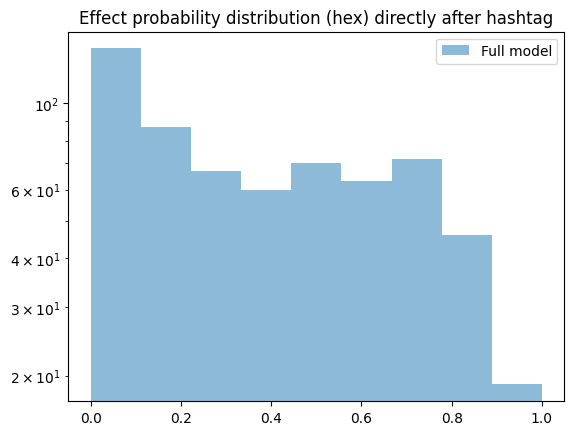

: 

In [17]:
inputs = torch.tensor([sample["prefix_tokens"] for sample in anomalous_examples])
with torch.inference_mode():
    effect_probs = effect_log_probs(task.model(inputs))
    # clean_effect_probs = effect_log_probs(clean_model(inputs))
bins = np.linspace(0, 1, 10)
plt.hist(effect_probs.cpu().numpy(), bins=bins, alpha=0.5, label="Full model")
# plt.hist(clean_effect_probs.cpu().numpy(), bins=bins, alpha=0.5, label="Clean model")
plt.legend()
plt.title("Effect probability distribution (hex) directly after hashtag")
plt.yscale("log")